In [1]:
# clustering - k-means

In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

In [3]:
# load dataset
digits = load_digits()
data = scale(digits.data) #Center to the mean and component wise scale to unit variance.

In [4]:
data.shape

(1797, 64)

In [5]:
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

In [6]:
labels

array([0, 1, 2, ..., 8, 9, 8])

In [7]:
sample_size = 300
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [8]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [9]:
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.15s	69432	0.602	0.650	0.625	0.465	0.598	0.146
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
random   	0.12s	69694	0.669	0.710	0.689	0.553	0.666	0.147


/Users/meizu/Work/py_env/my_scikit_learn/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [10]:
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

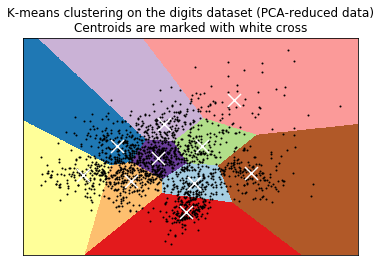

In [11]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [12]:
# clustering - BIRCH

In [13]:
from sklearn.cluster import Birch
from sklearn.datasets.samples_generator import make_blobs

In [14]:
# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis], # np.newaxis, convenient alias for None
                       np.ravel(yy)[:, np.newaxis]))


In [15]:
# Generate blobs to do a comparison between MiniBatchKMeans and Birch.
X, y = make_blobs(n_samples=100000, centers=n_centres, random_state=0)

In [16]:
# model
brich_0 = Birch(threshold=1.7, n_clusters=None)
brich_1 = Birch(threshold=1.7, n_clusters=100)

models = [brich_0, brich_1]
models_info = ['without global clustering', 'with global clustering']

Birch without global clustering: n_clusters 158, take 2.15 seconds
Birch with global clustering: n_clusters 100, take 2.09 seconds


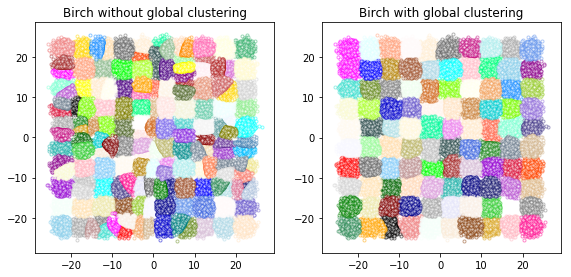

In [17]:
# trainning
from itertools import cycle
import matplotlib.colors as colors

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

for idx, (model, info) in enumerate(zip(models, models_info)):
    t_s = time()
    model.fit(X)
    t_d = time() - t_s
    
    labels = model.labels_
    centroids = model.subcluster_centers_
    n_clusters = np.unique(labels).size
    
    print("Birch %s: n_clusters %d, take %0.2f seconds" % (info, n_clusters, t_d))
          
    ax = fig.add_subplot(1, 3, idx + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1], c='w', edgecolor=col, marker='.', alpha=0.5)
    ax.set_title('Birch %s' % info)        

In [18]:
# clustering - DBSCAN

In [19]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [20]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)

X = StandardScaler().fit_transform(X)

In [21]:
# model
dbs = DBSCAN(eps=0.3, min_samples=10)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None)

In [22]:
# core_samples selection, excluding noise sample
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True 
labels = dbs.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [23]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"% metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883


Text(0.5,1,'Estimated number of clusters: 3')

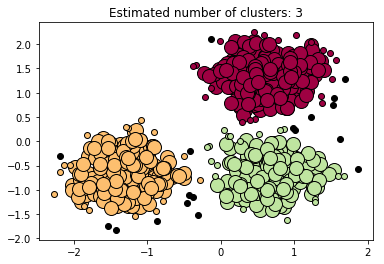

In [24]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k) # select specific cluster

    xy = X[class_member_mask & core_samples_mask] # make sure of a cluster and core sample
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask] # make sure of a cluster and noise sample
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

In [25]:
# clustering - SPECTRAL

In [26]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

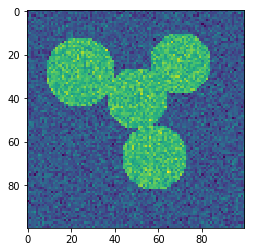

In [27]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# generating image 
img = circle1 + circle2 + circle3 + circle4

# image masker
mask = img.astype(bool)

# add noise
img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

plt.imshow(img)

In [28]:
# data prprocessing for clustering
graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

In [29]:
# model
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

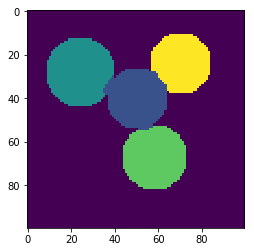

In [30]:
plt.imshow(label_im)